# MSDS 7331 - Mini Lab: Logistic Regression and SVMs


<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:5px;'>
    <h3>Lab Instructions</h3>
    <p>You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.
Write a report covering all the steps of the project. The format of the document can be PDF, *.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in the rendered iPython notebook. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.</p>
</div>

<a id='data_prep'></a>
## 1 - Data Preparation

In [70]:
#1.0.1 - Import the libraries we will need
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Graph Lab Support
import graphlab as gl
import graphlab
# keep data visualizations within notebook
graphlab.canvas.set_target('ipynb')

# Read in the crime data from the Lab 1 CSV file
dc = pd.read_csv('data/DC_Crime_2015_Lab1.csv')

### *** TO DO:
###  * Incorporate a feature for the weather conditions during START_DATE and END_DATE so we can use rainfall/max temp/min temp in the regression
dc['REPORT_DAT'] = pd.to_datetime(dc['REPORT_DAT'])
dc=dc.rename(columns = {'REPORT_DAT':'REPORT_DATE'})
dc['START_DATE'] = pd.to_datetime(dc['START_DATE'])
dc['END_DATE'] = pd.to_datetime(dc['END_DATE'])
dc['XBLOCK'] = dc['XBLOCK'].astype(np.float64)
dc['YBLOCK'] = dc['YBLOCK'].astype(np.float64)
dc['Crime_Month'] = dc["START_DATE"].map(lambda x: x.month)
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 27 columns):
REPORT_DATE             36489 non-null datetime64[ns]
SHIFT                   36489 non-null object
OFFENSE                 36489 non-null object
METHOD                  36489 non-null object
DISTRICT                36442 non-null float64
PSA                     36441 non-null float64
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
CCN                     36489 non-null int64
XBLOCK                  36489 non-null float64
YBLOCK                  36489 non-null float64
START_DATE              36489 non-null datetime64[ns]
END_DATE                36489 non-null datetime64[ns]
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int6

In [ ]:
# histogram of Crimes Month
dc['Crime_Month'].hist()
plt.title('Histogram of Crimes_Month')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
# histogram of Offense Code
dc['OFFENSE_Code'].hist()
plt.title('Histogram of Offense Code')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
# histogram of PSA ID"
dc['PSA_ID'].hist()
plt.title('Histogram of PSA_ID')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
# histogram of CRIME_TYPE"
dc['CRIME_TYPE'].hist()
plt.title('Histogram of CRIME_TYPE')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
#METHOD_Code
dc['METHOD_Code'].hist()
plt.title('Histogram of METHOD_Code')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
#DistrictID
dc['DistrictID'].hist()
plt.title('Histogram of DistrictID')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
#Ward
dc['WARD'].hist()
plt.title('Histogram of WARD')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
#VOTING_PRECINCT
dc['VOTING_PRECINCT'].hist()
plt.title('Histogram of VOTING_PRECINCT')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

### 1.1 - Dataset Review
We continue to use our dataset selected for lab 1 - the 2015 Washington, D.C. Metro Crime data.  That dataset contained the type of crime committed (Field name "OFFENSE"; from which we derived an "Offense_Code" field and ascribed a numeric value for each offense type (NOTE: The number used does not imply a level of severity they were simply applied in order of appearance).  :

|Offense|Offense_Code|Crime_Type|
|:------|:----------:|---------:|
|Theft/Other|1|2 (Property)|
|Theft from Auto|2|2 (Property)|
|Burglary|3|2 (Property)|
|Assault with Dangerous Weapon|4|1 (Violent)|
|Robbery|5|1 (Violent)|
|Motor Vehicle Theft|6|2 (Property)|
|Homicide|7|1 (Violent)|
|Sex Abuse|8|1 (Violent)|
|Arson|9|2 (Property)|

The dataset contains a variety of geographic identifiers representing different political, social, and legal boundaries.

DISTRICT -- the Police district within which the crime was committed<br>
Police Service Area (PSA) -- A subordinate area within a District<br>
Ward -- A political area, similar to a "county" in a larger state<br>
Advisory Neighborhood Committed (ANC) -- A social group consisting of neighbors and social leaders in a small geographic area<br>
Voting Precinct -- A political area for the management of voting residents<br>
Local Coordinates (XBLOCK and YBLOCK) -- location within the DC metro area based on the Maryland mapping system<br>
Global Coordinates (Latitude and Longitude) -- location on the planet<br>

There are also time-based identifiers provided in the data
* The Start and End dates/times of when the crime *might* have been committed.
* The date/time the crime was reported (i.e. when the police responded and took the report)
* These can be further decomposed to Seasons, Months, Weeks, Day of the Week, etc.
* Shift - the police duty shift that responded to the crime (broken into 8-hour periods within a day)

From these time-based data we could associate environmental conditions as well, including temperatures, rainfall, phase of the moon, etc.

These features give us a variety of ways to attempt to classify the data.

### 1.2 - Classification Tasks
We decided to take a look at two different classification processes with our data set.

#### 1.2.1 - Crime_Type (Violent/Property)
The second classification task is a binary classification, in which we attempt to build a model to predict whether the crime will be against a person (violent) or against property. Again, the goal is to help the Police manage resources more appropriately.

#### 1.2.2 - Offense/Offense_Code
For the first classification task, we chose to attempt building a model to predict the type of offense given the other features of the data (geographic location, time of day, political area, etc.).  The hope is that if a type of crime could be predicted, then the Police would be better able to allocate offense-specific resources appropriately.

#### 1.2.3 - Model Comparison
Secondarily, we seek to compare the accuracy of the models - i.e. if the Crime_Type prediction indicates a "Violent" crime, does the Offense prediction agree (Homicide, Sex Abuse, Robbery, or Assault).


<a id="model_building"></a>
## 2 - Model Building

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>SVM and Logistic Regression Modeling</h3>
    <ol><li>[<b>50 points</b>] Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.</li>
    <li>[<b>10 points</b>]  Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</li>
    <li>[<b>30 points</b>] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?</li>
    <li>[<b>10 points</b>]  Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.</li>
</ol>
</div>

### 2.1 - Logistic Regression Model for Crime_Type (Rubric Item 1)

In [2]:
#2.1.1 Dataset creation

#  The field "CRIME_TYPE" exists as 1 = Violent, and 2 = Property.  
#  We subtract from 2 to make it 1 = Violent, and 0 = Property
LRM_Response = 2 - dc["CRIME_TYPE"]
#print LRM_Response

#  What is the mean response
Mean_Response = LRM_Response.mean()
print "Mean response for the entire data set is " + str(Mean_Response)

Guess_Rate = 1.0 - Mean_Response
print "If we simply guessed 'Property' crime all the time, our accuracy would be " + str(Guess_Rate)

#  Set up model using all relevant features
LRM_Features = dc[["PSA_ID","WARD","ANC","NEIGHBORHOOD_CLUSTER","CENSUS_TRACT","VOTING_PRECINCT","SHIFT_Code","Latitude","Longitude","Crime_Month"]]
#print LRM_Features

#  Fit our model
LRM_Model = LogisticRegression()
LRM_Model = LRM_Model.fit(LRM_Features, LRM_Response)

#  How accurate is it?
Model_Acc = LRM_Model.score(LRM_Features, LRM_Response)
print "Accuracy of Logistic Regression model is " + str(Model_Acc)

if Model_Acc > Guess_Rate:
    print "The Logistic Regression model is better than simply guessing"
else:
    print "The Logistic Regression model is worse than simply guessing"


Mean response for the entire data set is 0.169174271698
If we simply guessed 'Property' crime all the time, our accuracy would be 0.830825728302
Accuracy of Logistic Regression model is 0.830250212393
The Logistic Regression model is worse than simply guessing


In [3]:
#  Display the coefficients to see if they tell us anything
pd.DataFrame(zip(LRM_Features.columns, np.transpose(LRM_Model.coef_)))

,0,1
0,PSA_ID,[0.00167783221638]
1,WARD,[0.0195928056189]
2,ANC,[0.00886350684632]
3,NEIGHBORHOOD_CLUSTER,[-0.00232184509213]
4,CENSUS_TRACT,[-1.37492426304e-05]
5,VOTING_PRECINCT,[0.0014077633811]
6,SHIFT_Code,[0.79779478674]
7,Latitude,[-0.0193099343437]
8,Longitude,[0.0475113614735]
9,Crime_Month,[0.00955306118479]


* The most significant factor is the SHIFT (i.e. the time of day)
* The second-most significant factor is Longitude, implying that as you move east, your chances of being involved in a violent crime increases
* The third-most significant factor is political WARD, so there are some Wards that are worse than others
* The fourth-most significant factor is Latitude, but negatively, so there is a greater chance of being involved in a violent crime as you move south

In [4]:
# Split the data into a training set and a test set (80/20)

LRM_XTrain, LRM_XTest, LRM_YTrain, LRM_YTest = train_test_split(LRM_Features, 
                                                                LRM_Response, 
                                                                test_size=0.2, 
                                                                random_state=0)

# Fit the same features against the training data
LRM_Model2 = LogisticRegression()
LRM_Model2.fit(LRM_XTrain, LRM_YTrain)

#  How accurate is it?
Model_Acc = LRM_Model2.score(LRM_Features, LRM_Response)
print "Accuracy of Logistic Regression model is " + str(Model_Acc)

if Model_Acc > Guess_Rate:
    print "The Logistic Regression model is better than simply guessing"
else:
    print "The Logistic Regression model is worse than simply guessing"


Accuracy of Logistic Regression model is 0.830250212393
The Logistic Regression model is worse than simply guessing


In [5]:
predicted = LRM_Model2.predict(LRM_XTest)
print predicted

# generate class probabilities
probs = LRM_Model2.predict_proba(LRM_XTest)
print probs

# generate evaluation metrics
print metrics.accuracy_score(LRM_YTest, predicted)
print metrics.roc_auc_score(LRM_YTest, probs[:, 1])

print metrics.confusion_matrix(LRM_YTest, predicted)
print metrics.classification_report(LRM_YTest, predicted)

[0 0 0 ..., 0 0 0]
[[ 0.63591626  0.36408374]
 [ 0.85595284  0.14404716]
 [ 0.91546692  0.08453308]
 ..., 
 [ 0.87553755  0.12446245]
 [ 0.8437132   0.1562868 ]
 [ 0.86308122  0.13691878]]
0.824746505892
0.721215251069
[[5918   83]
 [1196  101]]
             precision    recall  f1-score   support

          0       0.83      0.99      0.90      6001
          1       0.55      0.08      0.14      1297

avg / total       0.78      0.82      0.77      7298



In [7]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), 
                         LRM_Features,
                         LRM_Response, 
                         scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.83068493  0.83068493  0.83068493  0.83091258  0.83091258  0.83063853
  0.83086623  0.83114035  0.85032895  0.71984649]
0.821670050075


### 2.2 - Support Vector Machine Model for Crime_Type (Rubric Item 1)

### 2.3 - Logistic Regression Model for Offense_Code (Exceptional Work)

In [76]:
#2.1.1 Dataset creation

#  The field "OFFENSE_Code" exists as 1 = XX, and 2 = YY.  
#  LogisticRegression can handle multiple classes out-of-the-box.
#  http://stackoverflow.com/questions/36760000/python-how-to-use-multinomial-logistic-regression-using-sklearn
LRM_Response = dc["OFFENSE_Code"]
#print LRM_Response

my_custom_features = ["PSA_ID",
                      "WARD",
                      "ANC",
                      "NEIGHBORHOOD_CLUSTER",
                      "CENSUS_TRACT",
                      "VOTING_PRECINCT",
                      "SHIFT_Code",
                      "Crime_Month",
                      "DistrictID",
                      "Latitude",
                      "Longitude"]

#  Set up model using all relevant features
LRM_Features = dc[my_custom_features]
#print LRM_Features

In [ ]:
# flatten y into a 1-D array
#LRM_Response = np.ravel(LRM_Response)

# Logistic Regression

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [80]:
# instantiate a logistic regression model, and fit with LRM_Features and LRM_Response
#  Fit our model
LRM_Model3 = LogisticRegression()
LRM_Model3 = LRM_Model3.fit(LRM_Features, LRM_Response)

# check the accuracy on the training set
LRM_Model3.score(LRM_Features, LRM_Response)

0.38847323851023596

In [81]:
# what percentage had OFFENSE_Code?
LRM_Response.mean()

2.468634382964729

Let's examine the coefficients to see what we learn.

In [79]:
# examine the coefficients
pd.DataFrame(zip(LRM_Features.columns, np.transpose(LRM_Model.coef_)))

,0,1
0,PSA_ID,"[-0.00143186294287, -0.00049119232473, 0.00167..."
1,WARD,"[-0.0155910511983, 0.021165924796, 0.001403296..."
2,ANC,"[-0.00257727443538, -0.00899845726792, 0.00624..."
3,NEIGHBORHOOD_CLUSTER,"[-0.00888571463517, 0.00251005619651, 0.011269..."
4,CENSUS_TRACT,"[3.19102159784e-05, -2.16918498614e-05, -1.765..."
5,VOTING_PRECINCT,"[0.000678365084907, -0.00158752648825, -0.0038..."
6,SHIFT_Code,"[-0.0870797826679, -0.279117947383, -0.0035949..."
7,Crime_Month,"[0.00328111155299, -0.0105621734064, 0.0195225..."
8,DistrictID,"[0.000640286312876, 0.000166730427948, 4.01105..."
9,Latitude,"[-0.00321738499872, 0.0180227112641, -0.018151..."


# Each of the values listed in the table seems to be a vector of values

* The most significant factor is the CENSUS_TRACT (positive) 
* The second-most significant factor is SHIFT_Code (negative)
* The third-most significant factor is WARD (negative)
* The fourth-most significant factor is NEIGHBORHOOD_CLUSTER (negative)

In [82]:
# Split the data into a training set and a test set (80/20)

LRM_XTrain, LRM_XTest, LRM_YTrain, LRM_YTest = train_test_split(LRM_Features, 
                                                                LRM_Response, 
                                                                test_size=0.2, 
                                                                random_state=0)

# Fit the same features against the training data
LRM_Model4 = LogisticRegression()
LRM_Model4.fit(LRM_XTrain, LRM_YTrain)

#  How accurate is it?
Model_Acc = LRM_Model4.score(LRM_Features, LRM_Response)
print "Accuracy of Logistic Regression model is:\t{:04.2f}% ".format(Model_Acc*100)

Accuracy of Logistic Regression model is:	38.86% 


# Initial Attempt to Perform One Hot Encoding on the Categorical Variables

##### The Python kernel could not handle this and thru an error.

* Therefore, we had perform one hot encoding on each categorical variable individually

Transform all of the input categorical attributes within the final **DC DataFrame** --one for each possible variable outcome.  Here, we will use OneHotEncoding to take on each value for each variable attribute value.

Input Categorical Attributes/Features provided in the DC DataFrame
* **PSA_ID**
* **WARD**
* **ANC**
* **NEIGHBORHOOD_CLUSTER**
* **CENSUS_TRACT**
* **VOTING_PRECINCT**
* **DistrictID**
* **SHIFT_Code**
* **Crime_Month**

In [ ]:
# perform one-hot encoding of the categorical data "PSA_ID"
tmp_psa_id_df = pd.get_dummies(dc.PSA_ID, prefix='PSA_ID')
dc = pd.concat((dc,tmp_psa_id_df),axis=1) # add back into the dataframe

# perform one-hot encoding of the categorical data "WARD"
tmp_ward_df = pd.get_dummies(dc.WARD, prefix='WARD')
dc = pd.concat((dc,tmp_ward_df),axis=1) # add back into the dataframe

# perform one-hot encoding of the categorical data "ANC"
tmp_anc_df = pd.get_dummies(dc.ANC, prefix='ANC')
dc = pd.concat((dc,tmp_anc_df),axis=1) # add back into the dataframe

# perform one-hot encoding of the categorical data "NEIGHBORHOOD_CLUSTER"
tmp_NEIGHBORHOOD_CLUSTER_df = pd.get_dummies(dc.NEIGHBORHOOD_CLUSTER,prefix='NEIGHBORHOOD_CLUSTER')
dc = pd.concat((dc,tmp_NEIGHBORHOOD_CLUSTER_df),axis=1) # add back into the dataframe

# perform one-hot encoding of the categorical data "CENSUS_TRACT"
tmp_census_tract_df = pd.get_dummies(dc.CENSUS_TRACT,prefix='CENSUS_TRACT')
dc = pd.concat((dc,tmp_census_tract_df),axis=1) # add back into the dataframe

# VOTING_PRECINCT
tmp_VOTING_PRECINCT_df = pd.get_dummies(dc.VOTING_PRECINCT,prefix='VOTING_PRECINCT')
dc = pd.concat((dc,tmp_VOTING_PRECINCT_df),axis=1) # add back into the dataframe

# DistrictID
# perform one-hot encoding of the categorical data "DistrictID"
tmp_DistrictID_df = pd.get_dummies(dc.DistrictID,prefix='DistrictID')
dc = pd.concat((dc,tmp_DistrictID_df),axis=1) # add back into the dataframe

# SHIFT_Code
tmp_SHIFT_Code_df = pd.get_dummies(dc.SHIFT_Code,prefix='SHIFT_Code')
dc = pd.concat((dc,tmp_SHIFT_Code_df),axis=1) # add back into the dataframe

# Crime_Month
tmp_Crime_Month_df = pd.get_dummies(dc.Crime_Month,prefix='Crime_Month')
dc = pd.concat((dc,tmp_Crime_Month_df),axis=1) # add back into the dataframe

# Another attempt to write a loop to perform One Hot Encoding


###  This did not work either....

In [ ]:
my_custom_features = ["PSA_ID",
                      "WARD",
                      "ANC",
                      "NEIGHBORHOOD_CLUSTER",
                      "CENSUS_TRACT",
                      "VOTING_PRECINCT",
                      "DistrictID",
                      "SHIFT_Code",
                      "Crime_Month"]

for feature in my_custom_features:
    print feature
    temp_data_frame = pd.get_dummies(dc[feature], prefix = feature)
    dc = pd.concat((dc, temp_data_frame),axis=1) # add back into the dataframe)

In [ ]:
dc.info()

In [ ]:
# Now let's look a little further at each of the categorical objects. 
# Note that age range has already been saved as an ordinal. 

my_custom_features = ["PSA_ID",
                      "WARD",
                      "ANC",
                      "NEIGHBORHOOD_CLUSTER",
                      "CENSUS_TRACT",
                      "VOTING_PRECINCT",
                      "DistrictID",
                      "SHIFT_Code",
                      "Crime_Month"]

Transform all of the input categorical attributes within the final **DC DataFrame** --one for each possible variable outcome.  Here, we will use OneHotEncoding to take on each value for each variable attribute value.

Input Categorical Attributes/Features provided in the DC DataFrame
* **PSA_ID**
* **WARD**
* **ANC**
* **NEIGHBORHOOD_CLUSTER**
* **CENSUS_TRACT**
* **VOTING_PRECINCT**
* **DistrictID**
* **SHIFT_Code**
* **Crime_Month**



In [41]:
# perform one-hot encoding of the categorical data "PSA_ID"
tmp_psa_id_df = pd.get_dummies(dc.PSA_ID,prefix='PSA_ID')
dc = pd.concat((dc,tmp_psa_id_df),axis=1) # add back into the dataframe

In [42]:
# perform one-hot encoding of the categorical data "WARD"
tmp_ward_df = pd.get_dummies(dc.WARD,prefix='WARD')
dc = pd.concat((dc,tmp_ward_df),axis=1) # add back into the dataframe

In [43]:
# perform one-hot encoding of the categorical data "ANC"
tmp_anc_df = pd.get_dummies(dc.ANC,prefix='ANC')
dc = pd.concat((dc,tmp_anc_df),axis=1) # add back into the dataframe

In [44]:
# perform one-hot encoding of the categorical data "NEIGHBORHOOD_CLUSTER"
tmp_nc_df = pd.get_dummies(dc.NEIGHBORHOOD_CLUSTER,prefix='NEIGHBORHOOD_CLUSTER')
dc = pd.concat((dc,tmp_nc_df),axis=1) # add back into the dataframe

In [45]:
# perform one-hot encoding of the categorical data "CENSUS_TRACT"
tmp_census_tract_df = pd.get_dummies(dc.CENSUS_TRACT,prefix='CENSUS_TRACT')
dc = pd.concat((dc,tmp_census_tract_df),axis=1) # add back into the dataframe

In [46]:
# VOTING_PRECINCT
tmp_VOTING_PRECINCT_df = pd.get_dummies(dc.VOTING_PRECINCT,prefix='VOTING_PRECINCT')
dc = pd.concat((dc,tmp_VOTING_PRECINCT_df),axis=1) # add back into the dataframe

In [47]:
# DistrictID
# perform one-hot encoding of the categorical data "DistrictID"
tmp_DistrictID_df = pd.get_dummies(dc.DistrictID,prefix='DistrictID')
dc = pd.concat((dc,tmp_DistrictID_df),axis=1) # add back into the dataframe

In [48]:
# SHIFT_Code
tmp_SHIFT_Code_df = pd.get_dummies(dc.SHIFT_Code,prefix='SHIFT_Code')
dc = pd.concat((dc,tmp_SHIFT_Code_df),axis=1) # add back into the dataframe

In [49]:
# Crime_Month
tmp_Crime_Month_df = pd.get_dummies(dc.Crime_Month,prefix='Crime_Month')
dc = pd.concat((dc,tmp_Crime_Month_df),axis=1) # add back into the dataframe

In [50]:
dc.head()

,REPORT_DATE,SHIFT,OFFENSE,METHOD,DISTRICT,PSA,WARD,ANC,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,...,Crime_Month_3,Crime_Month_4,Crime_Month_5,Crime_Month_6,Crime_Month_7,Crime_Month_8,Crime_Month_9,Crime_Month_10,Crime_Month_11,Crime_Month_12
0,2015-03-04 12:05:00,DAY,THEFT/OTHER,OTHERS,3.0,305.0,1,12,3,4300,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2015-01-22 09:00:00,DAY,THEFT F/AUTO,OTHERS,4.0,408.0,1,14,2,2701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2015-01-03 21:20:00,EVENING,THEFT/OTHER,OTHERS,3.0,302.0,1,11,2,3000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-05 12:44:00,DAY,THEFT/OTHER,OTHERS,3.0,306.0,1,12,3,3400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015-01-20 07:01:00,DAY,THEFT F/AUTO,OTHERS,3.0,302.0,1,11,2,3000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### List the data set "dc" features/attributes

In [51]:
list(dc)

['REPORT_DATE',
 'SHIFT',
 'OFFENSE',
 'METHOD',
 'DISTRICT',
 'PSA',
 'WARD',
 'ANC',
 'NEIGHBORHOOD_CLUSTER',
 'CENSUS_TRACT',
 'VOTING_PRECINCT',
 'CCN',
 'XBLOCK',
 'YBLOCK',
 'START_DATE',
 'END_DATE',
 'PSA_ID',
 'DistrictID',
 'SHIFT_Code',
 'OFFENSE_Code',
 'METHOD_Code',
 'CRIME_TYPE',
 'AGE',
 'TIME_TO_REPORT',
 'Latitude',
 'Longitude',
 'Crime_Month',
 'PSA_ID_101',
 'PSA_ID_102',
 'PSA_ID_103',
 'PSA_ID_104',
 'PSA_ID_105',
 'PSA_ID_106',
 'PSA_ID_107',
 'PSA_ID_108',
 'PSA_ID_201',
 'PSA_ID_202',
 'PSA_ID_203',
 'PSA_ID_204',
 'PSA_ID_205',
 'PSA_ID_206',
 'PSA_ID_207',
 'PSA_ID_208',
 'PSA_ID_301',
 'PSA_ID_302',
 'PSA_ID_303',
 'PSA_ID_304',
 'PSA_ID_305',
 'PSA_ID_306',
 'PSA_ID_307',
 'PSA_ID_308',
 'PSA_ID_401',
 'PSA_ID_402',
 'PSA_ID_403',
 'PSA_ID_404',
 'PSA_ID_405',
 'PSA_ID_406',
 'PSA_ID_407',
 'PSA_ID_408',
 'PSA_ID_409',
 'PSA_ID_501',
 'PSA_ID_502',
 'PSA_ID_503',
 'PSA_ID_504',
 'PSA_ID_505',
 'PSA_ID_506',
 'PSA_ID_507',
 'PSA_ID_601',
 'PSA_ID_602',
 'PS

In [52]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Columns: 517 entries, REPORT_DATE to Crime_Month_12
dtypes: datetime64[ns](3), float64(496), int64(15), object(3)
memory usage: 143.9+ MB


In [53]:
dc.head()

,REPORT_DATE,SHIFT,OFFENSE,METHOD,DISTRICT,PSA,WARD,ANC,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,...,Crime_Month_3,Crime_Month_4,Crime_Month_5,Crime_Month_6,Crime_Month_7,Crime_Month_8,Crime_Month_9,Crime_Month_10,Crime_Month_11,Crime_Month_12
0,2015-03-04 12:05:00,DAY,THEFT/OTHER,OTHERS,3.0,305.0,1,12,3,4300,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2015-01-22 09:00:00,DAY,THEFT F/AUTO,OTHERS,4.0,408.0,1,14,2,2701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2015-01-03 21:20:00,EVENING,THEFT/OTHER,OTHERS,3.0,302.0,1,11,2,3000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-05 12:44:00,DAY,THEFT/OTHER,OTHERS,3.0,306.0,1,12,3,3400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015-01-20 07:01:00,DAY,THEFT F/AUTO,OTHERS,3.0,302.0,1,11,2,3000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clean up the dataset

* Remove Input features/attibutes without (W/O) dummy variables from the data set
* Remove Output features/attibutes variables from the data set


In [54]:
# Now let's clean up the dataset
# REMOVE INPUT FEATURES W/O Dummy Variables
if 'PSA_ID' in dc:
    del dc['PSA_ID'] # get rid of the original category as it is now one-hot encoded
    
if 'WARD' in dc:
    del dc['WARD'] # get rid of the original category as it is now one-hot encoded
    
if 'ANC' in dc:
    del dc['ANC'] # get rid of the original category as it is now one-hot encoded
    
if 'NEIGHBORHOOD_CLUSTER' in dc:
    del dc['NEIGHBORHOOD_CLUSTER'] # get rid of the original category as it is now one-hot encoded
    
if 'CENSUS_TRACT' in dc:    
    del dc['CENSUS_TRACT'] # get rid of the original category as it is now one-hot encoded
    
if 'VOTING_PRECINCT' in dc:    
    del dc['VOTING_PRECINCT'] # get rid of the original category as it is now one-hot encoded
    
if 'DistrictID' in dc:    
    del dc['DistrictID'] # get rid of the original category as it is now one-hot encoded
    
if 'SHIFT_Code' in dc:
    del dc['SHIFT_Code'] # get rid of the original category as it is now one-hot encoded
    
if 'Crime_Month' in dc:
    del dc['Crime_Month'] # get rid of the original category as it is now one-hot encoded

misc_input_features = ['REPORT_DATE',
                 'SHIFT',
                 'METHOD',
                 'DISTRICT',
                 'PSA',
                 'CCN',
                 'XBLOCK',
                 'YBLOCK',
                 'START_DATE',
                 'END_DATE',
                 'AGE',
                 'TIME_TO_REPORT']

for feature in misc_input_features:
    if feature in dc:
        del dc[feature]
   
output_features = ['OFFENSE',
                  'METHOD_Code',
                  'CRIME_TYPE']

for feature in output_features:
    if feature in dc:
        del dc[feature]
    
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Columns: 493 entries, OFFENSE_Code to Crime_Month_12
dtypes: float64(492), int64(1)
memory usage: 137.2 MB


#### List the data set "dc" features/attributes

In [55]:
list(dc)

['OFFENSE_Code',
 'Latitude',
 'Longitude',
 'PSA_ID_101',
 'PSA_ID_102',
 'PSA_ID_103',
 'PSA_ID_104',
 'PSA_ID_105',
 'PSA_ID_106',
 'PSA_ID_107',
 'PSA_ID_108',
 'PSA_ID_201',
 'PSA_ID_202',
 'PSA_ID_203',
 'PSA_ID_204',
 'PSA_ID_205',
 'PSA_ID_206',
 'PSA_ID_207',
 'PSA_ID_208',
 'PSA_ID_301',
 'PSA_ID_302',
 'PSA_ID_303',
 'PSA_ID_304',
 'PSA_ID_305',
 'PSA_ID_306',
 'PSA_ID_307',
 'PSA_ID_308',
 'PSA_ID_401',
 'PSA_ID_402',
 'PSA_ID_403',
 'PSA_ID_404',
 'PSA_ID_405',
 'PSA_ID_406',
 'PSA_ID_407',
 'PSA_ID_408',
 'PSA_ID_409',
 'PSA_ID_501',
 'PSA_ID_502',
 'PSA_ID_503',
 'PSA_ID_504',
 'PSA_ID_505',
 'PSA_ID_506',
 'PSA_ID_507',
 'PSA_ID_601',
 'PSA_ID_602',
 'PSA_ID_603',
 'PSA_ID_604',
 'PSA_ID_605',
 'PSA_ID_606',
 'PSA_ID_607',
 'PSA_ID_608',
 'PSA_ID_701',
 'PSA_ID_702',
 'PSA_ID_703',
 'PSA_ID_704',
 'PSA_ID_705',
 'PSA_ID_706',
 'PSA_ID_707',
 'PSA_ID_708',
 'WARD_1',
 'WARD_2',
 'WARD_3',
 'WARD_4',
 'WARD_5',
 'WARD_6',
 'WARD_7',
 'WARD_8',
 'ANC_11',
 'ANC_12',
 'ANC_

# Training and Testing Split
For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into scikit-learn.

In [56]:
from sklearn.cross_validation import ShuffleSplit

# we want to predict the X and y data as follows:
if 'OFFENSE_Code' in dc:
    y = dc['OFFENSE_Code'].values # get the labels we want
    del dc['OFFENSE_Code'] # get rid of the class label
    X = dc.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(36489, n_iter=3, test_size=0.2, random_state=None)


In [67]:
list(dc)

['Latitude',
 'Longitude',
 'PSA_ID_101',
 'PSA_ID_102',
 'PSA_ID_103',
 'PSA_ID_104',
 'PSA_ID_105',
 'PSA_ID_106',
 'PSA_ID_107',
 'PSA_ID_108',
 'PSA_ID_201',
 'PSA_ID_202',
 'PSA_ID_203',
 'PSA_ID_204',
 'PSA_ID_205',
 'PSA_ID_206',
 'PSA_ID_207',
 'PSA_ID_208',
 'PSA_ID_301',
 'PSA_ID_302',
 'PSA_ID_303',
 'PSA_ID_304',
 'PSA_ID_305',
 'PSA_ID_306',
 'PSA_ID_307',
 'PSA_ID_308',
 'PSA_ID_401',
 'PSA_ID_402',
 'PSA_ID_403',
 'PSA_ID_404',
 'PSA_ID_405',
 'PSA_ID_406',
 'PSA_ID_407',
 'PSA_ID_408',
 'PSA_ID_409',
 'PSA_ID_501',
 'PSA_ID_502',
 'PSA_ID_503',
 'PSA_ID_504',
 'PSA_ID_505',
 'PSA_ID_506',
 'PSA_ID_507',
 'PSA_ID_601',
 'PSA_ID_602',
 'PSA_ID_603',
 'PSA_ID_604',
 'PSA_ID_605',
 'PSA_ID_606',
 'PSA_ID_607',
 'PSA_ID_608',
 'PSA_ID_701',
 'PSA_ID_702',
 'PSA_ID_703',
 'PSA_ID_704',
 'PSA_ID_705',
 'PSA_ID_706',
 'PSA_ID_707',
 'PSA_ID_708',
 'WARD_1',
 'WARD_2',
 'WARD_3',
 'WARD_4',
 'WARD_5',
 'WARD_6',
 'WARD_7',
 'WARD_8',
 'ANC_11',
 'ANC_12',
 'ANC_13',
 'ANC_14',
 

# Logistic Regression


Now let's use Logistic Regression from scikit-learn. 

The documentation can be found here:
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [63]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

('====Iteration', 0, ' ====')
('accuracy', 0.45341189366949847)
('confusion matrix\n', array([[1927,  697,    9,   47,   46,   24,    0,    0,    0],
       [ 885, 1260,    4,   19,   23,   13,    0,    0,    0],
       [ 286,  182,   19,   19,   15,    9,    0,    0,    0],
       [ 264,  120,    5,   38,   45,    6,    0,    0,    0],
       [ 354,  235,    6,   41,   48,    4,    0,    0,    0],
       [ 260,  216,    5,   27,   28,   16,    0,    0,    0],
       [   9,    5,    0,    8,   10,    0,    0,    0,    0],
       [  28,   17,    1,    6,    3,    1,    0,    1,    0],
       [   2,    2,    0,    1,    2,    0,    0,    0,    0]]))
('====Iteration', 1, ' ====')
('accuracy', 0.46135927651411346)
('confusion matrix\n', array([[2008,  692,   19,   47,   44,   13,    0,    0,    0],
       [ 878, 1221,   14,    9,   26,   20,    0,    0,    0],
       [ 252,  196,   22,   15,   25,    7,    0,    0,    0],
       [ 250,  137,    9,   43,   38,    7,    1,    1,    0],
     

In [57]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

('====Iteration', 0, ' ====')
('accuracy', 0.46807344477939161)
('confusion matrix\n', array([[2010,  695,   15,   30,   42,   16,    0,    0,    0],
       [ 865, 1291,   15,   13,   28,   21,    0,    0,    0],
       [ 268,  164,   13,   24,   24,   10,    0,    0,    0],
       [ 236,  124,    6,   42,   39,    9,    0,    1,    0],
       [ 354,  208,    4,   33,   44,    4,    0,    0,    0],
       [ 291,  216,    2,   24,   20,   15,    0,    0,    0],
       [   6,    3,    0,    7,   10,    0,    0,    0,    0],
       [  20,   19,    1,    4,    6,    0,    0,    1,    0],
       [   3,    0,    0,    1,    1,    0,    0,    0,    0]]))
('====Iteration', 1, ' ====')
('accuracy', 0.45752260893395452)
('confusion matrix\n', array([[2021,  666,   11,   38,   40,   26,    0,    0,    0],
       [ 904, 1190,    4,   12,   29,   26,    0,    0,    0],
       [ 287,  185,   14,   23,   17,    5,    0,    0,    0],
       [ 247,  124,    1,   44,   42,   16,    0,    0,    0],
     

In [58]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.cross_validation import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[ 0.46451082  0.46026309  0.4620444 ]


In [59]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05))

[ 0.4643738   0.47286928  0.46067416]


<function __main__.lr_explor>

## Interpretting weights
Okay, so now lets take the last trained model for logistic regression and try to interpret the weights for the model. Is there something about the weights that makes this model more interpretable?

In [61]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = dc.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

('Latitude', 'has weight of', -0.0032600172508926405)
('Longitude', 'has weight of', 0.00938322837629906)
('PSA_ID_101', 'has weight of', -0.080773992804776401)
('PSA_ID_102', 'has weight of', -0.19933963003658131)
('PSA_ID_103', 'has weight of', -0.16322463079716154)
('PSA_ID_104', 'has weight of', -0.30859401146354631)
('PSA_ID_105', 'has weight of', -0.041639834523593995)
('PSA_ID_106', 'has weight of', 0.42991790521730072)
('PSA_ID_107', 'has weight of', 0.28458662039016236)
('PSA_ID_108', 'has weight of', 0.13154548899583551)
('PSA_ID_201', 'has weight of', 0.46267170417273307)
('PSA_ID_202', 'has weight of', 0.15856769334137066)
('PSA_ID_203', 'has weight of', 0.41397716359589742)
('PSA_ID_204', 'has weight of', -0.66130373497679562)
('PSA_ID_205', 'has weight of', -0.77668575727800404)
('PSA_ID_206', 'has weight of', 0.084767104320746953)
('PSA_ID_207', 'has weight of', 0.69680736776571239)
('PSA_ID_208', 'has weight of', -0.33894385441636071)
('PSA_ID_301', 'has weight of', -0.

These weight interpretations are not neccessarily interpretable because of the values we had. Very large attribute values could just as easily be assigned a higher weight. Instead, let's normalize the feature values so that all the attributes are on the same dynamic range. Once we normalize the attributes, the weights should have magnitudes that reflect their predictive power in the logistic regression model.

# ValueError:  a.any() or a.all()

**Code chokes at the zip_vars.sort() function call **

**  Ben Brock wrote email to Dr. Eric Carlson **

In [87]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print
print
print('accuracy:', acc )
print(conf )
print
print

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,dc.columns) # combine attributes
print
print

zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
'''
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
'''




('accuracy:', 0.46396272951493561)
[[1990  732   19   51   43   18    0    1    0]
 [ 869 1244   12   19   44   17    0    0    0]
 [ 253  176   27   16   18   10    0    0    0]
 [ 252  114    8   53   38    3    0    1    0]
 [ 309  221   11   39   58    2    0    0    0]
 [ 249  220   13   31   24   13    0    0    0]
 [   2    8    2    7   10    1    0    0    0]
 [  22   16    0    4    2    1    0    1    0]
 [   3    0    0    1    0    0    0    0    0]]






ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

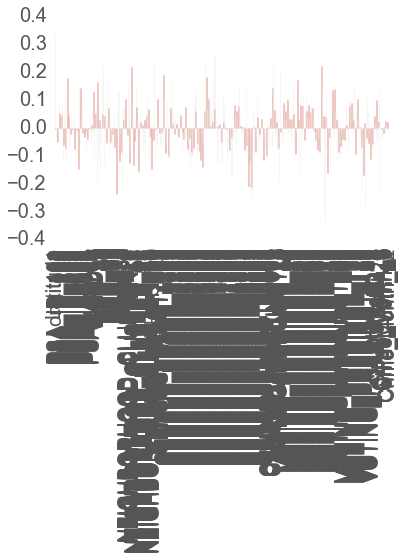

In [65]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=dc.columns)
weights.plot(kind='bar')
plt.show()

**For more improvement and guarding against overfitting:** At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. What variables would you remove?

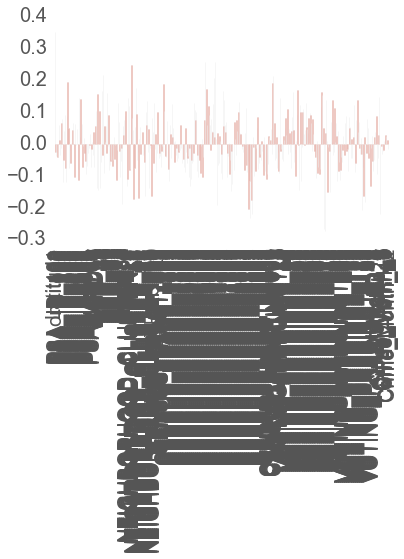

In [66]:
# you can also apply the StandardScaler function insied of the validation loop 
#  but this requires the use of PipeLines in scikit. Here is an example, but we will go over more 
#  thorough examples later in class

from sklearn.pipeline import Pipeline

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])

# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    
# it is a little odd getting trained objects from a  pipeline:
trained_model_from_pipeline = piped_object.named_steps['logit_model']

# now look at the weights
weights = pd.Series(trained_model_from_pipeline.coef_[0],index=dc.columns)
weights.plot(kind='bar')
plt.show()

### 2.4 - Support Vector Machine Model for Offense_Code (Exceptional Work)

### 2.5 - Advantages of Each Model (Rubric Item 2)

### 2.6 - Logistic Regression Weights (Rubric Item 3)

### 2.7 - Support Vectors (Rubric Item 4)